## RQ1: What is the accuracy of individual learners in predicting security vulnerabilities?
## Deliverables
1. Confusion matrix for each learner x 4 (1 for each learner) = 4 CMs.
2. Performance metrics (Accuracy, Precision and Recall) for each learner x 4 learners = 4 rows of metrics.
3. AUC-ROC curve for all learners x 1 combined graph = 1 AUC-ROC graph.

## Learners
1. Decision Tree Classifier
2. Logistic Regression
3. Naive Bayes Classifier
4. XGBoost Classifier

## Datasets
1. Apache Tomcat
2. Apache Struts2-core

### Prerequisites

In [31]:
# Basic imports
import numpy as np
import pandas as pd
import sys

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE

# Handling imbalance data
from imblearn.over_sampling  import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# CV
from sklearn.model_selection import StratifiedKFold

# Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import roc_curve

#ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

def preprocess(dataset_idx, target):
    ds = ["./datasets/tomcat-final.csv", "./datasets/struts-final.csv"]
    df = pd.read_csv(ds[dataset_idx])
    np.set_printoptions(threshold=np.inf)
    pd.set_option('max_columns', None)
    print(f"Dataframe {ds[dataset_idx][-16:]} created..\nTotal number of rows: ", df.shape[0])
    return split_features_variables(df, target)

def split_features_variables(df, target):
    y_cols = ['vulnerable', 'severity', 'title']
    feature_columns = df.columns[2:-4]
    label_mapping = []
    train, test = train_test_split(df, shuffle=True,test_size=0.2)
    X = train[feature_columns]
    test_X = test[feature_columns]
    if y_cols[target] == 'vulnerable':
        return X, test_X, train[y_cols[target]], test[y_cols[target]]      
    else: 
        label_X_train, label_X_test, label_mapping= label_encode(train, test, y_cols[target])
        return X, test_X, label_X_train[y_cols[target]], label_X_test[y_cols[target]], label_mapping      
    

def label_encode(train, test, target):
    print('Labelled target found..')
    train_target = train.copy()
    test_target = test.copy()
    df = train.append(test, ignore_index=True)
    le = LabelEncoder()
    le.fit(df[target])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_target[target] = le.transform(train[target])
    test_target[target] = le.transform(test[target])
    print('Encoded...')
    return train_target, test_target, le_name_mapping

def fit_feature_set(feature_set):
    global X_ros
    X_ros = X_ros[feature_set]
    global test_X
    test_X = test_X[feature_set]
  
def predict(model, target):
    kfold = StratifiedKFold(n_splits=10)
    cv_model = cross_validate(model,X_ros,y_ros,cv=kfold,return_estimator=True)
    scores = list(cv_model['test_score'])
    idx = scores.index(max(cv_model['test_score']))
    cv_model = cv_model['estimator'][idx]
    predictions = cv_model.predict(test_X)
    pred_proba = cv_model.predict_proba(test_X)
    average = ''
    if target != 0:
      average = 'micro'
    else:
      average = 'binary'
    accuracy = accuracy_score(test_Y, predictions)
    precision = precision_score(test_Y, predictions, average=average)
    recall = recall_score(test_Y, predictions,average=average)
    return [accuracy, precision, recall,pred_proba ,predictions]

### Experiments


In [65]:
ds = 1
target = 2
fs = 1
feature_set = ['sfs','rfe']
datasets = ['Tomcat', 'Struts']
targets = ['Vulnerable','Severity', 'Title']
label_mappings = []
if target == 0:
  X, test_X, y, test_Y = preprocess(ds, target)
else:
  X, test_X, y, test_Y, label_mappings = preprocess(ds, target)
print(f'Positive classes in train: {len(y.loc[y==1])}')
print(f'Positive classes in test: {len(test_Y.loc[test_Y==1])}')
ros = RandomUnderSampler(sampling_strategy='majority')
X_ros, y_ros = ros.fit_resample(X, y)
print(f'Positive classes after train sampling: {len(y_ros.loc[y_ros==1])}')
print(f'Total length after sampling: {len(y_ros)}')
if len(label_mappings) > 0:
  labels = label_mappings.keys()
  values = label_mappings.values()
  print(pd.DataFrame([labels, values]).T)

Dataframe struts-final.csv created..
Total number of rows:  19372
Labelled target found..
Encoded...
Positive classes in train: 11
Positive classes in test: 1
Positive classes after train sampling: 11
Total length after sampling: 39
                                                 0  1
0                                                0  0
1                        Access Restriction Bypass  1
2                Cross-site Request Forgery (CSRF)  2
3                          Denial of Service (DoS)  3
4                     Improper Action Name Cleanup  4
5     Regular Expression Denial of Service (ReDoS)  5
6                            Remote Code Execution  6
7                      Remote Code Execution (RCE)  7
8  Unrestricted Upload of File with Dangerous Type  8


### Feature selection

In [ ]:
# Sequential Forward Selector
sfs = SFS(DecisionTreeClassifier(), 
          direction='forward',
          scoring='precision_micro')
sfs.fit(X_ros,y_ros)
sfs_features = []
for i in range(X.shape[1]):
    if(sfs.support_[i] == 1):
        sfs_features.append(X.columns[i])

# Recursive Feature Eliminator
rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X_ros, y_ros)
rfe_features = []
for i in range(X.shape[1]):
    if(rfe.support_[i] == 1):
        rfe_features.append(X.columns[i])

### Machine Learning

Feature set: RFE

-----Model: Decision Tree-----
Accuracy: 0.17548387096774193
Precision: 0.17548387096774193
Recall: 0.17548387096774193


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,



-----Model: Logistic Regression-----
Accuracy: 0.05187096774193548
Precision: 0.05187096774193548
Recall: 0.05187096774193548

-----Model: Naive Bayes-----
Accuracy: 0.0005161290322580645
Precision: 0.0005161290322580645
Recall: 0.0005161290322580645


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


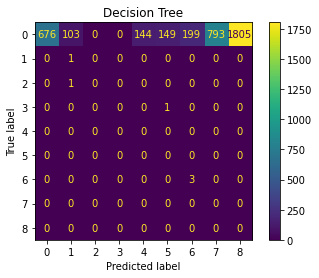

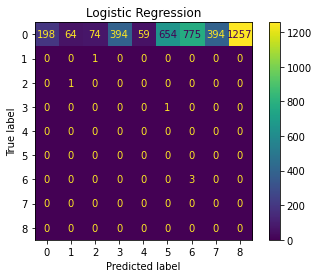

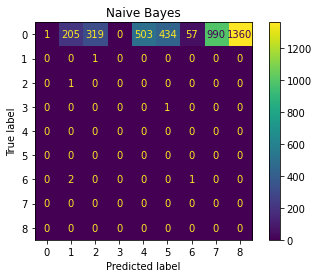

In [66]:
# Fitting the feature sets.
print(f'Feature set: {feature_set[fs].upper()}\n')
if fs == 0:
  fit_feature_set(sfs_features)
else:
  fit_feature_set(rfe_features)

# Decision Tree
dt = DecisionTreeClassifier(splitter='best',ccp_alpha=0.036)
dt_pred_arr = predict(dt,target)
dt_pred = dt_pred_arr[-2]
print('-----Model: Decision Tree-----')
print(f'Accuracy: {mean(dt_pred_arr[0])}')
print(f'Precision: {mean(dt_pred_arr[1])}')
print(f'Recall: {mean(dt_pred_arr[2])}')
dt_fig = CMD.from_predictions(test_Y,dt_pred_arr[-1])
dt_fig.ax_.set_title('Decision Tree')
print(dt_fig)

# Logistic Regression
lr = LogisticRegression(solver='liblinear',max_iter=500 ,class_weight='balanced')
lr_pred_arr = predict(lr,target)
lr_pred = lr_pred_arr[-2]
print('\n-----Model: Logistic Regression-----')
print(f'Accuracy: {mean(lr_pred_arr[0])}')
print(f'Precision: {mean(lr_pred_arr[1])}')
print(f'Recall: {mean(lr_pred_arr[2])}')
lr_fig = CMD.from_predictions(test_Y,lr_pred_arr[-1])
lr_fig.ax_.set_title('Logistic Regression')
print(lr_fig)

# Naive Bayes
nb = GaussianNB()
nb_pred_arr = predict(nb,target)
nb_pred = nb_pred_arr[-2]
print('\n-----Model: Naive Bayes-----')
print(f'Accuracy: {mean(nb_pred_arr[0])}')
print(f'Precision: {mean(nb_pred_arr[1])}')
print(f'Recall: {mean(nb_pred_arr[2])}')
nb_fig = CMD.from_predictions(test_Y,nb_pred_arr[-1])
nb_fig.ax_.set_title('Naive Bayes')
print(nb_fig)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,



-----Model: XGBoost Classifier-----
Accuracy: 0.01625806451612903
Precision: 0.01625806451612903
Recall: 0.01625806451612903


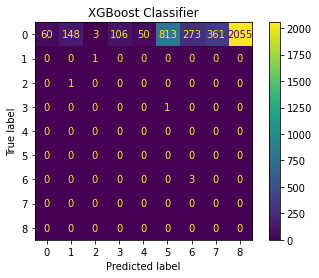

In [67]:
# XGBoost
if target == 0:
  xgb = XGBClassifier(n_estimators=500, objective='binary:logistic')
else:
  xgb = XGBClassifier(n_estimators=500, objective='multi:softmax')
xgb_pred_arr = predict(xgb,target)
xgb_pred = xgb_pred_arr[-2]
print('\n-----Model: XGBoost Classifier-----')
print(f'Accuracy: {mean(xgb_pred_arr[0])}')
print(f'Precision: {mean(xgb_pred_arr[1])}')
print(f'Recall: {mean(xgb_pred_arr[2])}')
xgb_fig = CMD.from_predictions(test_Y,xgb_pred_arr[-1])
xgb_fig.ax_.set_title('XGBoost Classifier')
print(xgb_fig)

#### AUC-ROC curve

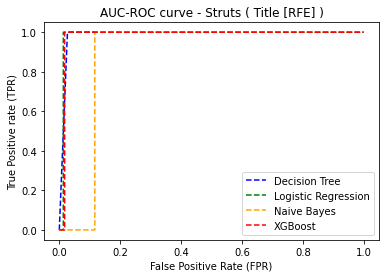

In [68]:
# roc curve for models
fpr = {}
tpr = {}
thresh ={}
    
fpr1, tpr1, thresh1 = roc_curve(test_Y, dt_pred[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(test_Y, lr_pred[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(test_Y, nb_pred[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(test_Y, xgb_pred[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_Y))]
p_fpr, p_tpr, _ = roc_curve(test_Y, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='blue', label='Decision Tree')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Logistic Regression')
plt.plot(fpr3, tpr3, linestyle='--',color='orange', label='Naive Bayes')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='XGBoost')

# title
plt.title('AUC-ROC curve - '+datasets[ds]+' ( '+targets[target]+' ['+feature_set[fs].upper()+'] )')
# x label
plt.xlabel('False Positive Rate (FPR)')
# y label
plt.ylabel('True Positive rate (TPR)')

plt.legend(loc='best')
plt.show();